# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](https://github.com/hse-ds/iad-intro-ds/blob/master/2023/homeworks/hw07-trees/meme.jpg?raw=1) -->
<img src="https://github.com/hse-ds/iad-intro-ds/blob/master/2023/homeworks/hw07-trees/meme.jpg?raw=1" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [81]:
np.round(-0.8*np.log2(0.8)-0.2*np.log2(0.2), 2)

0.72

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [82]:
np.round(0.2*(1-0.2) + 0.8*(1-0.8) - 0.8 * 0 - 0.2 * 0, 2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [83]:
np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [84]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [85]:
#ассистент в чате написал, что тут, якобы, немного ошиблись в названиях. Цитирую "где требуют ginis и gini_best, нужно выводить
#значение критерия информативности ,которое Q(R_m,j,t)"
#раз уж он это сказал, сделаю так. Вещи, в конце концов, взаимосвязанные

In [86]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    thresholds = np.sort(np.unique(feature_vector))
    if len(thresholds)==1:
      return (thresholds, thresholds, 0, -1)
    if feature_type == 'categorical':
      ginis = np.vectorize(cat_feature_split_score, excluded = ['f_vec','t_vec'])(f_vec = feature_vector, t_vec = target_vector, threshold = thresholds, t= task)
      ind = np.argmax(ginis)
      threshold_best = thresholds[ind]
      gini_best = ginis[ind]
    else:
      thresholds = (thresholds[:len(thresholds)-1]+thresholds[1:])/2
      ginis = np.vectorize(real_feature_split_score, excluded = ['f_vec','t_vec'])(f_vec = feature_vector, t_vec = target_vector, threshold = thresholds, t= task)
      ind = np.argmax(ginis)
      threshold_best = thresholds[ind]
      gini_best = ginis[ind]
    return (thresholds, ginis, threshold_best, gini_best)

def real_feature_split_score(f_vec, t_vec, threshold, t):
  mask = f_vec<=threshold
  left = t_vec[mask]
  right = t_vec[~mask]
  if t == 'classification':
    return H_gini(t_vec)- len(left)/len(t_vec)* H_gini(left) - len(right)/len(t_vec)* H_gini(right)
  else:
    return H_disp(t_vec)- len(left)/len(t_vec)* H_disp(left) - len(right)/len(t_vec)* H_disp(right)


def cat_feature_split_score(f_vec, t_vec, threshold, t):
    mask = f_vec == threshold
    left = t_vec[mask]
    right = t_vec[~mask]
    if t == 'classification':
      return H_gini(t_vec)- len(left)/len(t_vec)* H_gini(left) - len(right)/len(t_vec)* H_gini(right)
    else:
      return H_disp(t_vec)- len(left)/len(t_vec)* H_disp(left) - len(right)/len(t_vec)* H_disp(right)

def H_disp(R):
    R_mean = np.mean(R)
    return np.matmul(R-R_mean, R-R_mean)/len(R)

def H_gini(R):
    p_array = np.vectorize(gini_help, excluded = ['target'])(target = R, x=np.unique(R))
    return np.matmul(p_array, 1-p_array)
def gini_help(target, x):
  return np.mean(target==x)

Эту функцию можно протестировать на датасете `California`.

In [87]:
from sklearn.datasets import fetch_california_housing

In [88]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [89]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [90]:
#см. комментарий выше про написанное в чате ассистентом
t,g,t_best,g_best = find_best_split(X.MedInc, y, 'regresion', 'real')

Text(0.5, 1.0, 'Зависимость прироста информации от выбора порога')

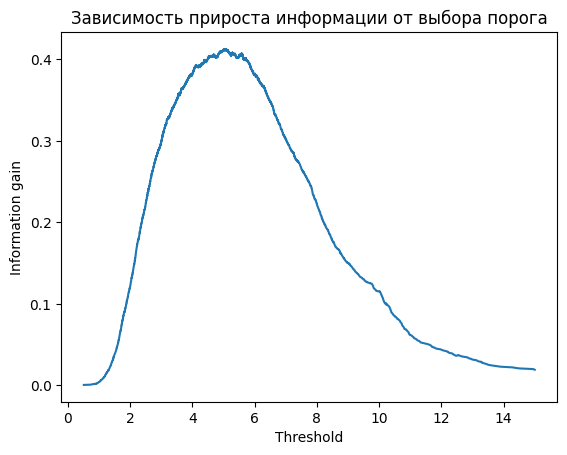

In [91]:
plt.plot(t,g)
plt.xlabel('Threshold')
plt.ylabel('Information gain')
plt.title('Зависимость прироста информации от выбора порога')

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [93]:
t_best #если имеется ввиду только признак MedInc, то лучший предикат - это "MedInc<=5.03515"
#но я перебрал (ниже) остальные признаки, это быстро, ибо везде regression и real. И MedInc всё равно остался лучшим выбором (с соответствующим порогом, конечно)

5.03515

In [94]:
for col in X.columns:                          #надеюсь, это за цикл не считается, я мог и руками 8 строчек прописать. Векторизация бы тут ничего не улучшила
  print(find_best_split(X[col], y, 'regresion', 'real')[3], col)

0.41275138620167673 MedInc
0.030900940598320575 HouseAge
0.15920795258922454 AveRooms
0.015253415595942843 AveBedrms
0.0028306480479901586 Population
0.07391870577793169 AveOccup
0.09033408765371931 Latitude
0.050211052033030446 Longitude


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [95]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <=threshold_best    ###
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector==threshold_best###
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type']=='terminal':
          return node['class']
        else:
          if node.get('category_split')==None:
            if x[node['feature_split']]<=node['threshold']:
              return self._predict_node(x, node['left_child'])
            else:
              return self._predict_node(x, node['right_child'])
          else:
            if x[node['feature_split']]==node['category_split']:
              return self._predict_node(x, node['left_child'])
            else:
              return self._predict_node(x, node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [96]:
df = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2023/homeworks/hw07-trees/students.csv')
df.head()
df.drop(columns = 'Unnamed: 0', inplace = True)

In [97]:
y = df.UNS
X = df.drop(columns='UNS')

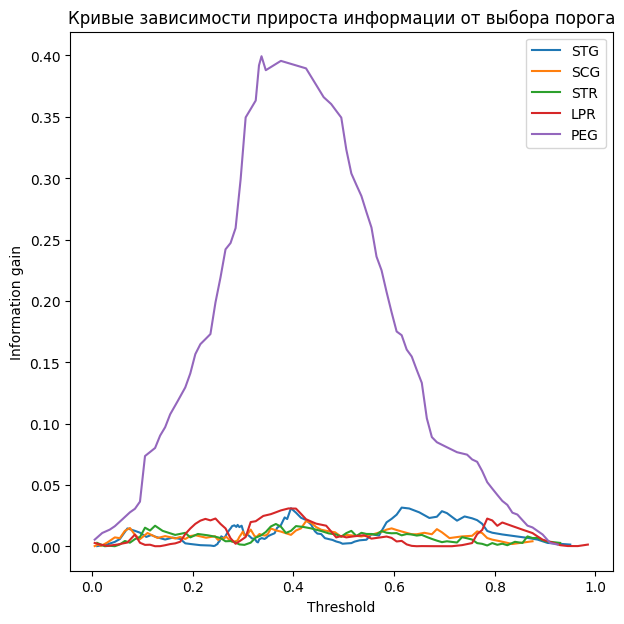

In [98]:
#снова смотри про слова ассистента
plt.figure(figsize=(7,7))
plt.title('Кривые зависимости прироста информации от выбора порога')
plt.xlabel('Threshold')
plt.ylabel('Information gain')
for col in X.columns: #опять же, цикл для компактности, я мог и вручную продублировать это 5 раз (меня уже выбесил np.vectorize,
#я целый день потратил на попытки понять, что ему не нравится. А тот просто в какой-то момент работал, в какой-то нет (на абсолютно одном и том же коде))
  t,g = find_best_split(X[col], y, 'classification','real')[:2]
  plt.plot(t,g, label = str(col))
plt.legend()

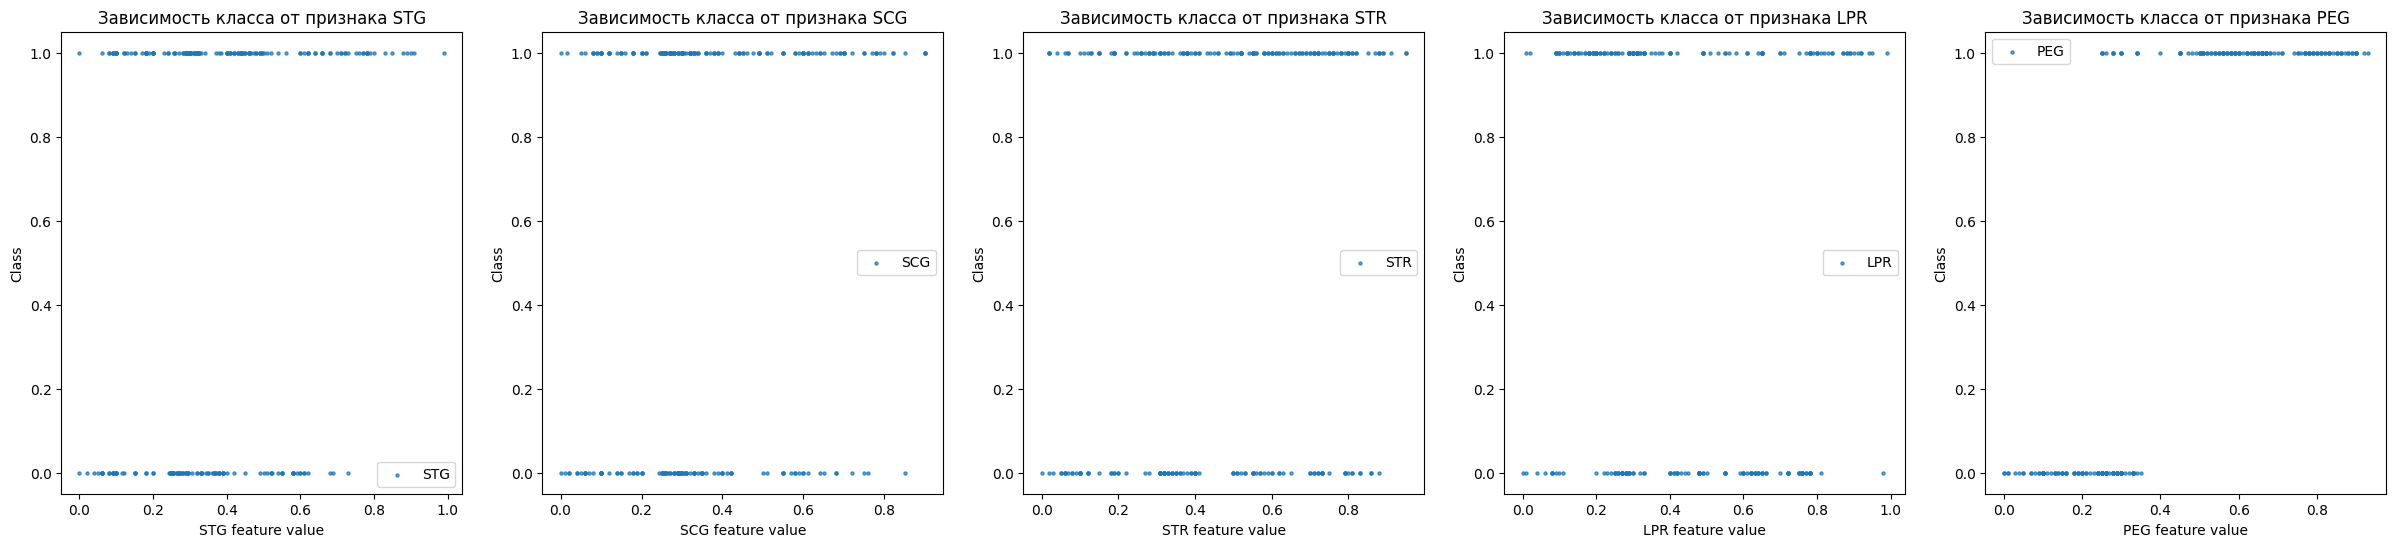

In [57]:
plt.figure(figsize=(30,6))
i=1
for col in X.columns:
  plt.subplot(1,5,i)
  plt.scatter(X[col],y, alpha=0.7, s=5, label = str(col))
  plt.title('Зависимость класса от признака '+str(col))
  plt.xlabel(str(col)+' feature value')
  plt.ylabel('Class')
  i+=1
  plt.legend()
  #P.S. Тыкни на диаграммы рассеивания, они станут больше

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [58]:
#Исходя из кривых - явно по признаку PEG (и порогу около 0.35, ну да ладно). Так как именно на PEG кривой (т.е. при разбиении по признаку PEG)
#мы видим самые большие значения Q (то есть сильнее всего уменьшаем хаотичность)

#Да результат отлично согласуется с диаграммами рассеивания!
#сразу видно, что на диаграмме для PEG (и только там), можно выбрать такой порог (= провести вертикальную линию), что слева
#почти все объекты будут одного класса, а справа - почти все объекты другого. Это и значит, что предикат с этим признаком позволяет хорошо разделять объекты
#по классам

#P.S. Подозреваю, что хотели спросить про "вид ДИАГРАММ РАССЕИВАНИЯ для "хороших" признаков", ну да ладно, напишу и то, и то, на всякий случай
#уж больно я подозрительный, извините...

#вид диаграмм рассеивания  для "хороших" признаков - то, что я уже сказал выше: когда можно провести вертикальную прямую (то есть выбрать порог), которая
#хорошо разделит классы (по одну сторону будут (с хорошей точностью) только объекты нулевого класса, по другую - сильно преобладать первый класс)
#другими словами, диаграмма рассеивания должна быть очень похожа на график функции "индикатор [a,b]"(где отрезок [a,b] вложен в отрезок множества значений
#признака, имеет с ним общий конец, но не два конца. Вырожденный случай или случай полного совпадения с отрезком значений больно особенны
# - это бы значило, что все объекты в выборке одного класса

#вид диаграмм рассеивания для кривых, по которым деление практически невозможно - смотря что имеется ввиду. Хочется сказать "не такие, как я описал выше"
#если под "делением" имеется ввиду идеально отделить первый класс от второго - то это такие диаграммы, что как ни проводи вертикальную прямую,
#хотя бы с одной стороны от неё будут находиться в большом количестве объекты обоих классов

#Отсюда плавно можно перейти к "вид кривой для "хороших" признаков":
#если по признаку можно разделить выборку идеально, то кривая будет выглядеть как для PEG - иметь максимум в "наилучшем пороге" и +- стабильно убывать в обе стороны
#если деление практически невозможно, то кривая уже не имеет такого выраженного "максимума" и является горизонтальной или многократно скачет вверх-вниз
#что и можно наблюдать на примере кривых для оставшихся четырёх признаков

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [99]:
data = pd.read_csv('/content/agaricus-lepiota.data')

In [100]:
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [101]:
from sklearn.preprocessing import LabelEncoder
X = data.apply(LabelEncoder().fit_transform)

In [102]:
y = X.p
X.drop(columns = ['p'], inplace = True)

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 77)

In [104]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [105]:
tree = DecisionTree(feature_types = ['categorical']*22)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
print(np.mean(y_test==predictions)) #accuracy. Чудеса

1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [106]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [107]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

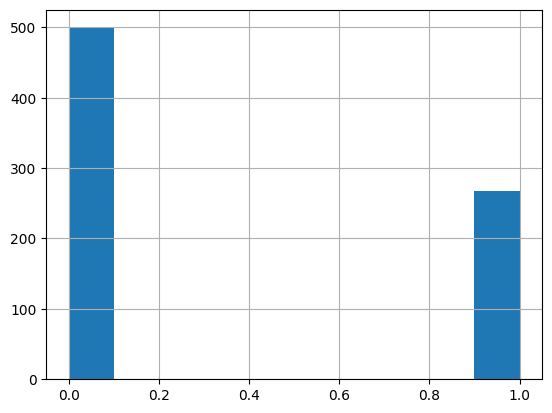

In [108]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [109]:
y = data['Outcome']
X = data.drop(columns=['Outcome'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 77)
X_train_train, X_train_vad, y_train_train, y_train_vad = train_test_split(X_train, y_train, test_size = 0.3, random_state = 78)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [110]:
#всё за меня importнули, а f1-меру - нет. Может, это знак. Посчитаю её через precision и recall
max_depth_array = np.arange(1,20)
min_samples_leaf_array = np.arange(1,30)
f1_best, a_best, b_best = -1, 0, 0
for a in max_depth_array:
  for b in min_samples_leaf_array:
    tree = DecisionTreeClassifier(max_depth = a, min_samples_leaf = b, random_state=25)
    tree.fit(X_train_train,y_train_train)
    pred = tree.predict(X_train_vad)
    r, p = recall_score(y_train_vad, pred), precision_score(y_train_vad, pred)
    f = 2*p*r/(p+r)
    if f1_best< f:
      f1_best = f
      a_best, b_best = a, b
print(f1_best, a_best, b_best)

#кажется, лучший результат показали min_samples_leaf = 24 и глубина дерева 4

0.6666666666666667 4 24


In [113]:
good_tree = DecisionTreeClassifier(max_depth= 4, min_samples_leaf = 24)
good_tree.fit(X_train, y_train)
pred = good_tree.predict(X_test)
pred_proba = good_tree.predict_proba(X_test)
print('Accuracy:', accuracy_score(y_test, pred),
      'Precision:', precision_score(y_test, pred),
      'Recall:', recall_score(y_test, pred),
      'ROC-AUC:', roc_auc_score(y_test, pred_proba[:,1]))

Accuracy: 0.7402597402597403 Precision: 0.6140350877192983 Recall: 0.4794520547945205 ROC-AUC: 0.7603173226981098


In [72]:
#не знаю, нужно ли комментировать результат. Далеко не огонь, конечно, но бывало и хуже.

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [115]:
b_clf = BaggingClassifier(n_estimators=50, random_state=25)
b_clf.fit(X_train, y_train)
pred = b_clf.predict(X_test)
pred_proba = b_clf.predict_proba(X_test)
print('Accuracy:', accuracy_score(y_test, pred),
      'Precision:', precision_score(y_test, pred),
      'Recall:', recall_score(y_test, pred),
      'ROC-AUC:', roc_auc_score(y_test, pred_proba[:,1]))

Accuracy: 0.7489177489177489 Precision: 0.6056338028169014 Recall: 0.589041095890411 ROC-AUC: 0.7726720998786197


In [74]:
#Сильно ничего не изменилось, кроме recall, который подрос аж на 10%. Так что, в общем, качество улучшилось.
#Неудивительно. За это композиции деревьев и любят больше самих деревьев. Думаю, сейчас мы немного уменьшили переобучение

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [116]:
#это моя кросс-валидация "на коленке", хотелось попробовать, дальше будет проведено ещё раз с помощью уже написанных (не мною) методов
from sklearn.metrics import f1_score
max_depth_array = np.arange(1,15)
min_samples_split_array = np.arange(2,30)
border = len(X_train)//3
X1, X2, X3, y1, y2, y3 = X_train[:border],X_train[border:2*border],X_train[2*border:],y_train[:border],y_train[border:2*border],y_train[2*border:]
X12,y12 = pd.concat([X1,X2]), pd.concat([y1,y2])
X13,y13 = pd.concat([X1, X3]),pd.concat([y1,y3])
X23,y23 = pd.concat([X2,X3]),pd.concat([y2,y3])
f_best, depth_best, sam_num_best = -1,0,0
for depth in max_depth_array:
  for sam_num in min_samples_split_array:
    forest = RandomForestClassifier(n_estimators = 50, max_depth = depth, min_samples_split = sam_num, random_state=25)
    forest.fit(X12,y12)
    pred = forest.predict(X3)
    f1_1 = f1_score(y3,pred)
    forest.fit(X13,y13)
    pred = forest.predict(X2)
    f1_2 = f1_score(y2,pred)
    forest.fit(X23,y23)
    pred = forest.predict(X1)
    f1_3 = f1_score(y1,pred)
    f = (f1_1+f1_2+f1_3)/3
    if f>f_best:
      f_best = f
      depth_best,sam_num_best = depth,sam_num
print(f_best, depth_best, sam_num_best)
#выдало 12 и 16

0.6717224772982348 12 16


In [117]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
#отсюда взял cross_val_score
from sklearn.model_selection import cross_val_score
max_depth_array = np.arange(1,15)
min_samples_split_array = np.arange(2,30)
f_best, depth_best, sam_num_best = -1,0,0
for depth in max_depth_array:
  for sam_num in min_samples_split_array:
    forest = RandomForestClassifier(n_estimators = 50, max_depth = depth, min_samples_split = sam_num, random_state=25)
    f1 = np.mean(cross_val_score(forest, X_train, y_train, cv = 5, scoring = 'f1'))
    if f1>f_best:
      f_best = f1
      depth_best,sam_num_best = depth,sam_num
print(f_best, depth_best, sam_num_best)

#выдал 14 и 8. Отличается от того, что было получено выше. Ну, либо я где-то накосячил, либо виноват рандом и разное кол-во фолдов: тут 5, выше 3

0.6680844780809406 14 8


In [120]:
#наконец, обучимся с подобранными гиперпараметрами и проверим качество:
forest_cool = RandomForestClassifier(n_estimators = 50, max_depth = 14, min_samples_split=8, random_state=25)
forest_cool.fit(X_train, y_train)
pred = forest_cool.predict(X_test)
pred_proba = forest_cool.predict_proba(X_test)
print('Accuracy:', accuracy_score(y_test, pred),
      'Precision:', precision_score(y_test, pred),
      'Recall:', recall_score(y_test, pred),
      'ROC-AUC:', roc_auc_score(y_test, pred_proba[:,1]))

Accuracy: 0.7619047619047619 Precision: 0.625 Recall: 0.6164383561643836 ROC-AUC: 0.7962545517600139


In [ ]:
#хуже всего себя показал DecisionTreeClassifier. Первое место, пожалуй, достаётся случайному лесу!
#Дерево:         Accuracy: 0.7402597402597403   Precision: 0.6140350877192983   Recall: 0.4794520547945205   ROC-AUC: 0.7603173226981098
#Бэггинг:        Accuracy: 0.7489177489177489   Precision: 0.6056338028169014   Recall: 0.589041095890411    ROC-AUC: 0.7726720998786197
#Случайный лес:  Accuracy: 0.7619047619047619   Precision: 0.625                Recall: 0.6164383561643836   ROC-AUC: 0.7962545517600139

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [ ]:
#не уверен, имеется ли ввиду случайный лес с параметрами, как выше, или с дефолтными параметрами, поэтому на всякий случай сделаю и так, и так

100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


Text(0, 0.5, 'AUC_ROC')

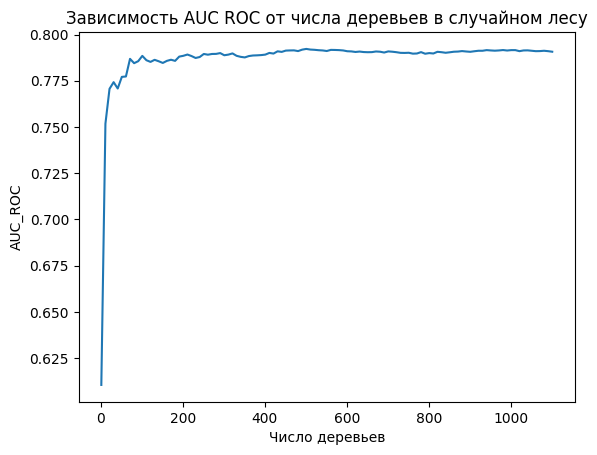

In [78]:
#БЕЗ ПАРАМЕТРОВ
from tqdm import tqdm
roc_auc = []
for n in tqdm(np.arange(1,1111,10)):
  n_forest = RandomForestClassifier(n_estimators=n, random_state=23)
  n_forest.fit(X_train, y_train)
  roc_auc.append(roc_auc_score(y_test, n_forest.predict_proba(X_test)[:,1]))
plt.plot(np.arange(1,1111,10),roc_auc)
plt.title("Зависимость AUC ROC от числа деревьев в случайном лесу")
plt.xlabel('Число деревьев')
plt.ylabel('AUC_ROC')

100%|██████████| 111/111 [01:33<00:00,  1.19it/s]


Text(0, 0.5, 'AUC_ROC')

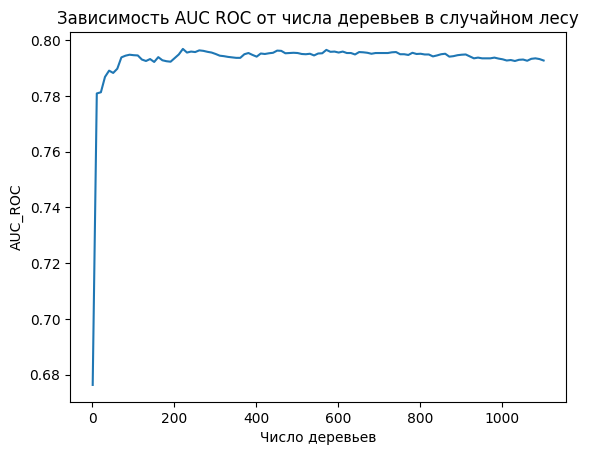

In [79]:
#с параметрами:
roc_auc2 = []
for n in tqdm(np.arange(1,1111,10)):
  n_forest = RandomForestClassifier(max_depth = 14, min_samples_split = 8, n_estimators=n, random_state=23)
  n_forest.fit(X_train, y_train)
  roc_auc2.append(roc_auc_score(y_test, n_forest.predict_proba(X_test)[:,1]))
plt.plot(np.arange(1,1111,10),roc_auc2)
plt.title("Зависимость AUC ROC от числа деревьев в случайном лесу")
plt.xlabel('Число деревьев')
plt.ylabel('AUC_ROC')

In [ ]:
#качественно картинка одинакова в обоих случаях
#Выводы: решающий лес не начинает переобучаться с ростом числа деревьев! (нас этому и учили). То есть ошибка на тестовой выборке
#(или, наоборот, как здесь, мера качества) выходит на асимптоту при росте числа деревьев (а не падает, что произошло бы при переобучении)

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

Text(0, 0.5, 'Важность')

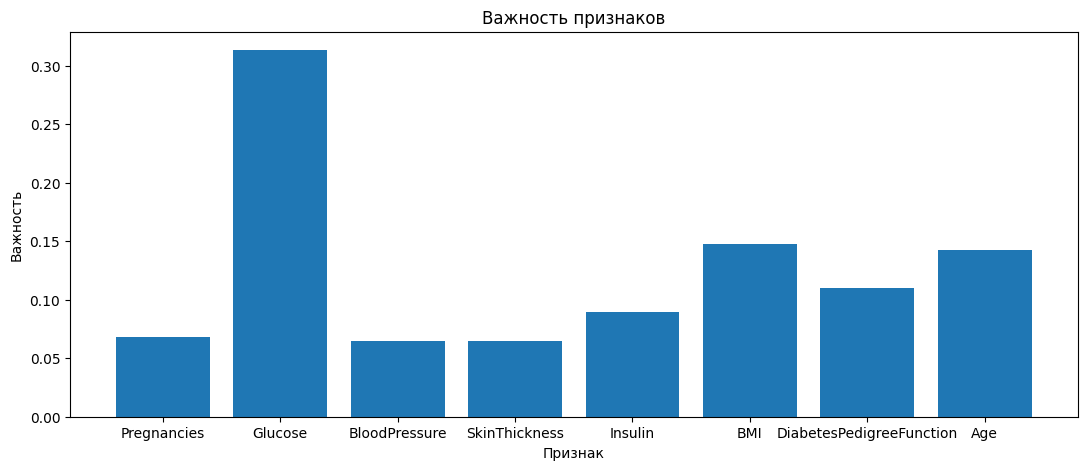

In [123]:
forest = RandomForestClassifier(n_estimators = 50, max_depth = 14, min_samples_split = 8, random_state=25)
forest.fit(X_train, y_train)
plt.figure(figsize=(13,5))
plt.bar(X_train.columns, forest.feature_importances_)
plt.title('Важность признаков')
plt.xlabel('Признак')
plt.ylabel('Важность')
#самым важным оказался уровень глюкозы. Пожалуй, я не удивлён.